In [116]:
import difflib
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alive_progress import alive_bar
from sentence_transformers import SentenceTransformer, util

from generate_training_data import clean_text
from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_colwidth', 300)

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# read in matched data
corpus_df = pd.read_pickle("matched_data.pickle")
corpus_df_wo_abstracts = pd.read_pickle("matched_data_wo_abstracts.pickle")
corpus_df_wo_linebreaks = pd.read_pickle("matched_data_wo_linebreaks.pickle")
corpus_df_wo_linebreaks_wo_abstracts = pd.read_pickle("matched_data_wo_abstracts_wo_linebreaks.pickle")

In [38]:
def clean_text(text, skip=False):
    if not skip:
        allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ0-9.,;:!?()'\"-]"
        text = re.sub(allowed_chars, ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

    return text

In [3]:
print('with linebreaks')
print(f'{corpus_df.shape=}\t\t{corpus_df_wo_abstracts.shape=}')
print(f'Percent of data in full transcriptions:\t\t{corpus_df_wo_abstracts.shape[0] / corpus_df.shape[0]:.1%}')
print()
print('without linebreaks')
print(f'{corpus_df_wo_linebreaks.shape=}\t\t{corpus_df_wo_linebreaks_wo_abstracts.shape=}')
print(f'Percent of data in full transcriptions:\t\t{corpus_df_wo_linebreaks_wo_abstracts.shape[0] / corpus_df_wo_linebreaks.shape[0]:.1%}')

with linebreaks
corpus_df.shape=(887164, 4)		corpus_df_wo_abstracts.shape=(848724, 4)
Percent of data in full transcriptions:		95.7%

without linebreaks
corpus_df_wo_linebreaks.shape=(778951, 4)		corpus_df_wo_linebreaks_wo_abstracts.shape=(740463, 4)
Percent of data in full transcriptions:		95.1%


In [4]:
print(f"DataFrame size (corpus_df): {corpus_df.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")
print(f"DataFrame size (corpus_df_wo_abstracts): {corpus_df_wo_abstracts.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")
print(f"DataFrame size (corpus_df_wo_linebreaks): {corpus_df_wo_linebreaks.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")
print(f"DataFrame size (corpus_df_wo_linebreaks_wo_abstracts): {corpus_df_wo_linebreaks_wo_abstracts.memory_usage(deep=True).sum() / (1024 ** 2):.1f} MB")

DataFrame size (corpus_df): 500.9 MB
DataFrame size (corpus_df_wo_abstracts): 482.1 MB
DataFrame size (corpus_df_wo_linebreaks): 369.4 MB
DataFrame size (corpus_df_wo_linebreaks_wo_abstracts): 350.7 MB


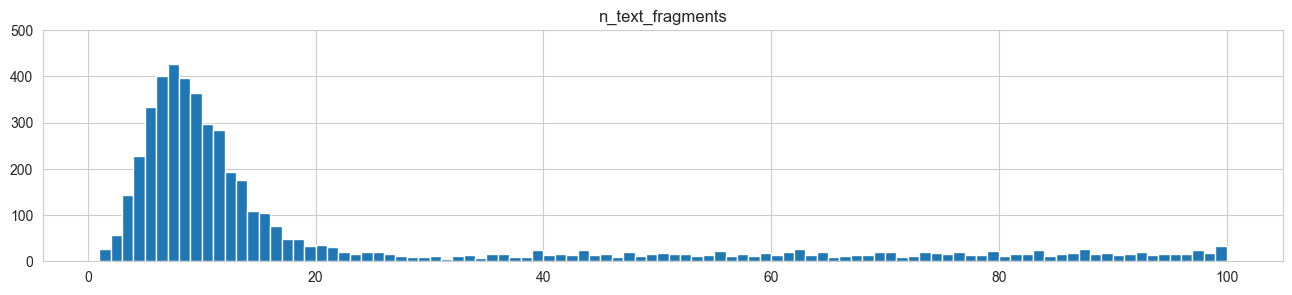

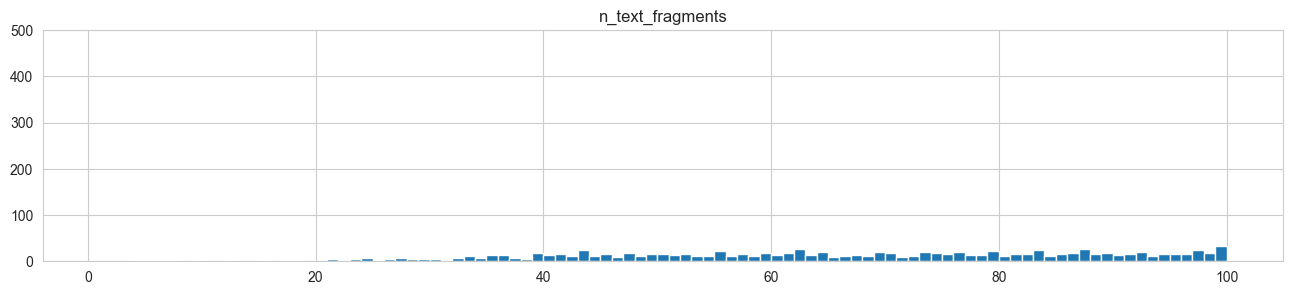

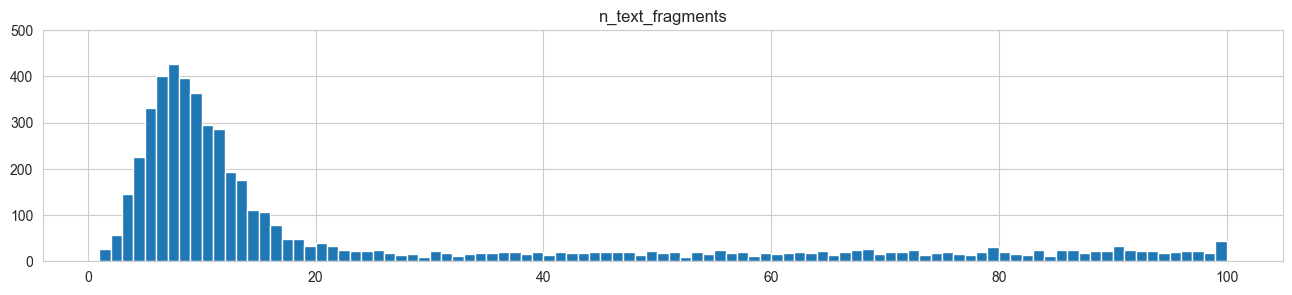

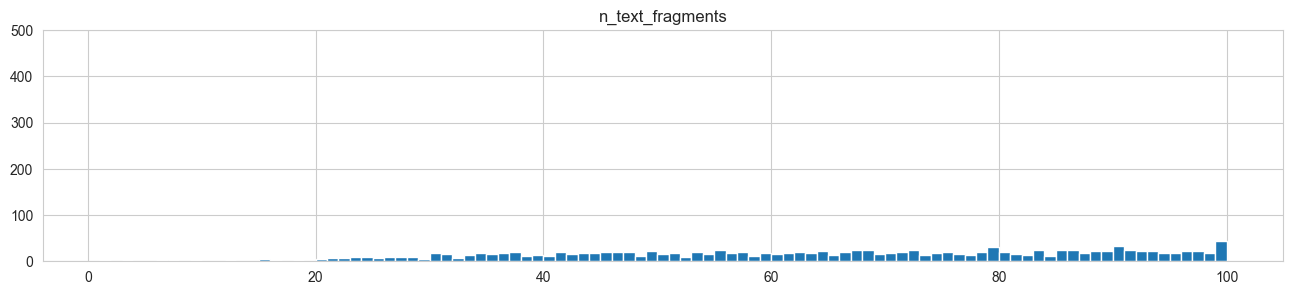

In [5]:
def plot_pub_number_hist(dataframe, y_max=500, bins=None, figsize=(16, 3)):
    corpus_value_counts = pd.DataFrame(dataframe.pub_number.value_counts())
    corpus_value_counts.columns = ['n_text_fragments']
    bins = bins if bins else [x + 1 for x in range(100)]
    
    fig, ax = plt.subplots(figsize=figsize)
    corpus_value_counts.hist(
        bins=bins,
        ax=ax
    )
    ax.set_ylim(0, y_max) 
    plt.show()


plot_pub_number_hist(corpus_df)
plot_pub_number_hist(corpus_df_wo_abstracts)
plot_pub_number_hist(corpus_df_wo_linebreaks)
plot_pub_number_hist(corpus_df_wo_linebreaks_wo_abstracts)

In [6]:
pd.concat([
    corpus_df.describe().rename({'similarity': 'similarity'}, axis=1),
    corpus_df_wo_abstracts.describe().rename({'similarity': 'wo_abstracts_similarity'}, axis=1),
    corpus_df_wo_linebreaks.describe().rename({'similarity': 'wo_linebreaks_similarity'}, axis=1),
    corpus_df_wo_linebreaks_wo_abstracts.describe().rename({'similarity': 'wo_linebreaks_wo_abstracts_similarity'}, axis=1),
], axis=1).T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
similarity,0.842,0.073,0.700,0.783,0.846,0.901,1.000
wo_abstracts_similarity,0.842,0.073,0.700,0.784,0.847,0.902,1.000
wo_linebreaks_similarity,0.842,0.072,0.700,0.784,0.847,0.901,1.000
wo_linebreaks_wo_abstracts_similarity,0.843,0.072,0.700,0.785,0.847,0.902,1.000


In [7]:
pd.concat([
    corpus_df[corpus_df.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'similarity_lte20'}, axis=1),
    corpus_df_wo_abstracts[corpus_df_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'wo_abstracts_similarity_lte20'}, axis=1),
    corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'wo_linebreaks_similarity_lte20'}, axis=1),
    corpus_df_wo_linebreaks_wo_abstracts[corpus_df_wo_linebreaks_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") <= 20].describe().rename({'similarity': 'wo_linebreaks_wo_abstracts_similarity_lte20'}, axis=1),
    corpus_df[corpus_df.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'similarity_gt20'}, axis=1),
    corpus_df_wo_abstracts[corpus_df_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'wo_abstracts_similarity_gt20'}, axis=1),
    corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'wo_linebreaks_similarity_gt20'}, axis=1),
    corpus_df_wo_linebreaks_wo_abstracts[corpus_df_wo_linebreaks_wo_abstracts.groupby("pub_number")["pub_number"].transform("count") > 20].describe().rename({'similarity': 'wo_linebreaks_wo_abstracts_similarity_gt20'}, axis=1),
], axis=1).T

# TODO: conclusion, >20 sentences is best, removing linebreaks looks best, but excluding abstracts, then still having <20 is the worst 
#  maybe the best: df = corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > 20]

,count,mean,std,min,25%,50%,75%,max
similarity_lte20,33028.000,0.822,0.073,0.700,0.757,0.824,0.879,0.992
wo_abstracts_similarity_lte20,259.000,0.810,0.070,0.700,0.754,0.806,0.861,0.984
wo_linebreaks_similarity_lte20,33209.000,0.822,0.073,0.700,0.756,0.824,0.879,0.992
wo_linebreaks_wo_abstracts_similarity_lte20,415.000,0.810,0.072,0.700,0.746,0.804,0.863,0.982
similarity_gt20,854136.000,0.842,0.073,0.700,0.784,0.847,0.902,1.000
wo_abstracts_similarity_gt20,848465.000,0.842,0.073,0.700,0.784,0.847,0.902,1.000
wo_linebreaks_similarity_gt20,745742.000,0.843,0.072,0.700,0.785,0.847,0.902,1.000
wo_linebreaks_wo_abstracts_similarity_gt20,740048.000,0.843,0.072,0.700,0.785,0.847,0.902,1.000


# check for repeats in appendices

In [8]:
pd.concat([
    pd.DataFrame(corpus_df.pub_number.value_counts().describe()).rename({'count': 'n_sentences'}, axis=1),
    pd.DataFrame(corpus_df_wo_abstracts.pub_number.value_counts().describe()).rename({'count': 'n_sentences_wo_abstracts'}, axis=1),
    pd.DataFrame(corpus_df_wo_linebreaks.pub_number.value_counts().describe()).rename({'count': 'n_sentences_wo_linebreaks'}, axis=1),
    pd.DataFrame(corpus_df_wo_linebreaks_wo_abstracts.pub_number.value_counts().describe()).rename({'count': 'n_sentences_wo_linebreaks_wo_abstracts'}, axis=1),
], axis=1)

,n_sentences,n_sentences_wo_abstracts,n_sentences_wo_linebreaks,n_sentences_wo_linebreaks_wo_abstracts
count,7796.000,3879.000,7796.000,3874.000
mean,113.797,218.800,99.917,191.137
std,197.840,237.962,172.979,208.776
min,1.000,1.000,1.000,1.000
25%,8.000,91.000,8.000,79.000
50%,26.000,150.000,25.000,131.000
75%,149.000,259.000,130.000,227.000
max,3957.000,3957.000,3316.000,3316.000


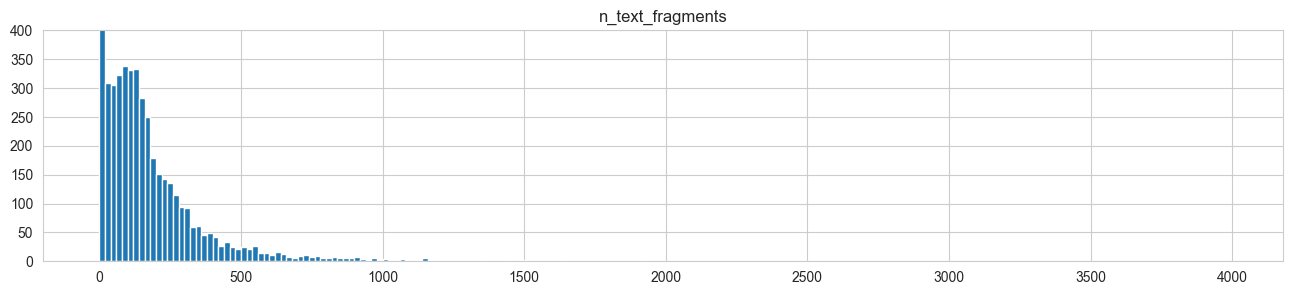

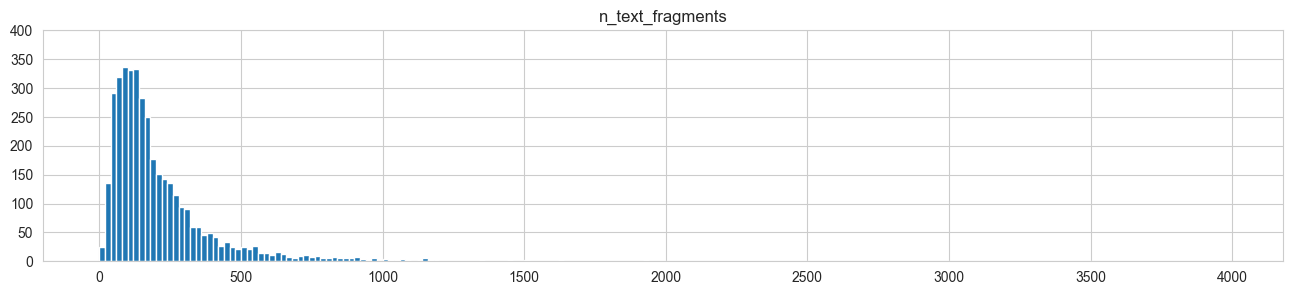

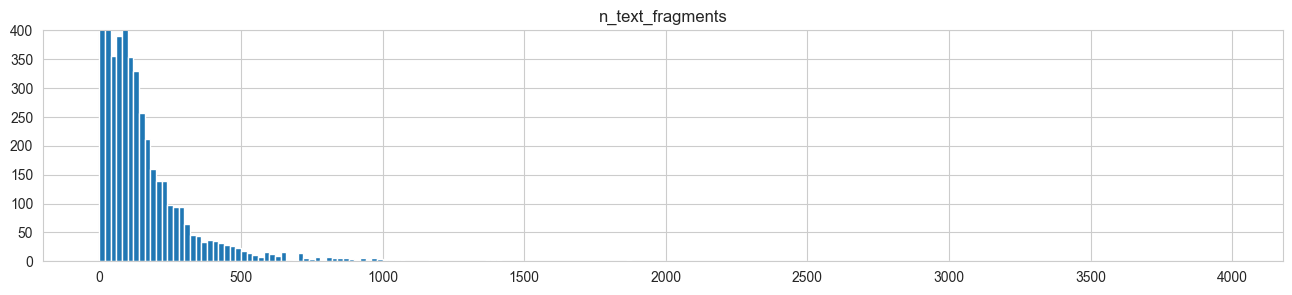

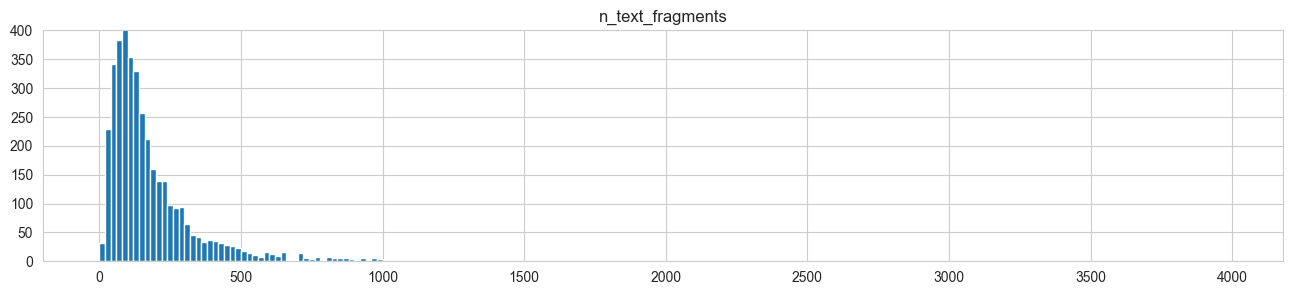

In [9]:
bins = [x for x in range(0, 4000, 20)]
y_max = 400
plot_pub_number_hist(corpus_df, bins=bins, y_max=y_max)
plot_pub_number_hist(corpus_df_wo_abstracts, bins=bins, y_max=y_max)
plot_pub_number_hist(corpus_df_wo_linebreaks, bins=bins, y_max=y_max)
plot_pub_number_hist(corpus_df_wo_linebreaks_wo_abstracts, bins=bins, y_max=y_max)

# will skipping linebreaks when cleaning fix appendix related false matches? (looks like yes a bit)

In [127]:
sentence_encoder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


def create_similarity_matrix(sentences, sentence_encoder):
    embeddings = sentence_encoder.encode(sentences, convert_to_tensor=True)
    return util.pytorch_cos_sim(embeddings, embeddings)


def plot_similarity_heatmap_grid(similarity_matrix, approx_size=200, low_similarity=0.5, high_similarity=0.7, matched_pairs=None, cmap=None, norm=None):
    if similarity_matrix.shape[0] < approx_size:
        figsize=(6, 6)
        fig, ax = plt.subplots(figsize=figsize) 
        
        if cmap:
            if norm:
                sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, linewidths=0, ax=ax)
            else:
                sns.heatmap(similarity_matrix, cmap=cmap, cbar=False, linewidths=0, ax=ax)
        else:
            cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
            bounds = [0, low_similarity, high_similarity, 1]
            norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
            sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, linewidths=0, ax=ax)
    
        if matched_pairs:
            x_coords, y_coords = zip(*matched_pairs)
            ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', markersize=4, linewidth=1.5)
    
        ax.tick_params(left=False, bottom=False)
    
        plt.tight_layout()
        plt.show()
    
    else:
        blocks = np.array_split(range(similarity_matrix.shape[0]), similarity_matrix.shape[0] // approx_size)
    
        n_blocks = len(blocks)
        n_cols = 2
        n_rows = (n_blocks + n_cols - 1) // n_cols
    
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
        axes = axes.flatten()
    
        if not cmap:
            cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
            bounds = [0, low_similarity, high_similarity, 1]
            norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
        for i, block in enumerate(blocks):
            x0, x1 = block[0], block[-1] + 1
            ax = axes[i] if i < len(axes) else None
            
            if ax:
                sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, linewidths=0, ax=ax)
                ax.set_title(f"From {x0} to {x1}")
                ax.tick_params(left=False, bottom=False)
    
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
    
        plt.tight_layout()
        plt.show()


def get_random_similarity_matrix(dataframe, sentence_encoder, pub_number=None, lang='en'):
    pub_number = pub_number if pub_number else random.choice(dataframe['pub_number'].unique()) 
    sentences = dataframe[dataframe['pub_number'] == pub_number][lang].to_list()
    
    return create_similarity_matrix(sentences, sentence_encoder)
    
    
def plot_random_similarity_heatmap(dataframe, sentence_encoder, pub_number=None, lang='en'):
    if pub_number:
        plot_similarity_heatmap_grid(get_random_similarity_matrix(dataframe, sentence_encoder, pub_number, lang=lang))
    else:
        plot_similarity_heatmap_grid(get_random_similarity_matrix(dataframe, sentence_encoder, lang=lang))
        

def get_random_pub_number():
    return random.choice(dataframe['pub_number'].unique()) 
       
        

In [135]:
def plot_both_language_heatmaps(dataframe, sentence_encoder, pub_number=None, low_similarity=0.5, high_similarity=0.7, matched_pairs=None, cmap=None, norm=None):
    pub_number = pub_number if pub_number else get_random_pub_number()
    
    sim_matrix_fr = get_random_similarity_matrix(dataframe, sentence_encoder, pub_number=pub_number, lang='fr')
    sim_matrix_en = get_random_similarity_matrix(dataframe, sentence_encoder, pub_number=pub_number, lang='en')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.flatten()

    if not cmap:
        cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
        bounds = [0, low_similarity, high_similarity, 1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

    for i, similarity_matrix in enumerate([sim_matrix_fr, sim_matrix_en]):
        ax = axes[i]
        ax.set_title(f"{'French Similarity Matrix' if i == 0 else 'English Similarity Matrix'}")
        sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, linewidths=0, ax=ax)

    plt.tight_layout()
    plt.show()
    

SAR 2024/023
with linebreaks


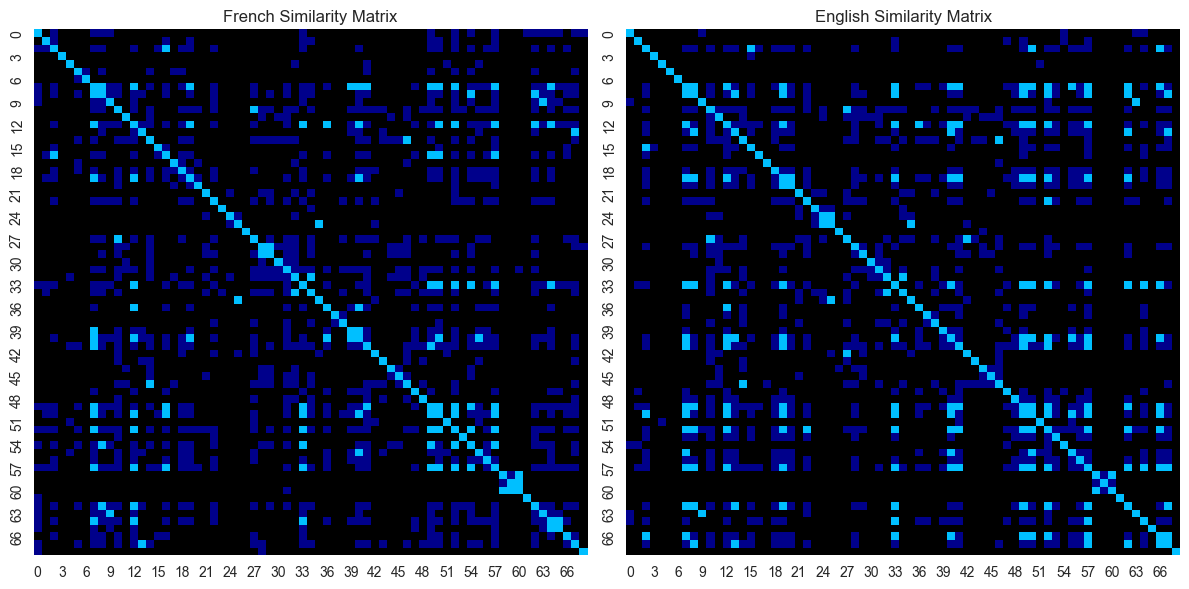

without linebreaks


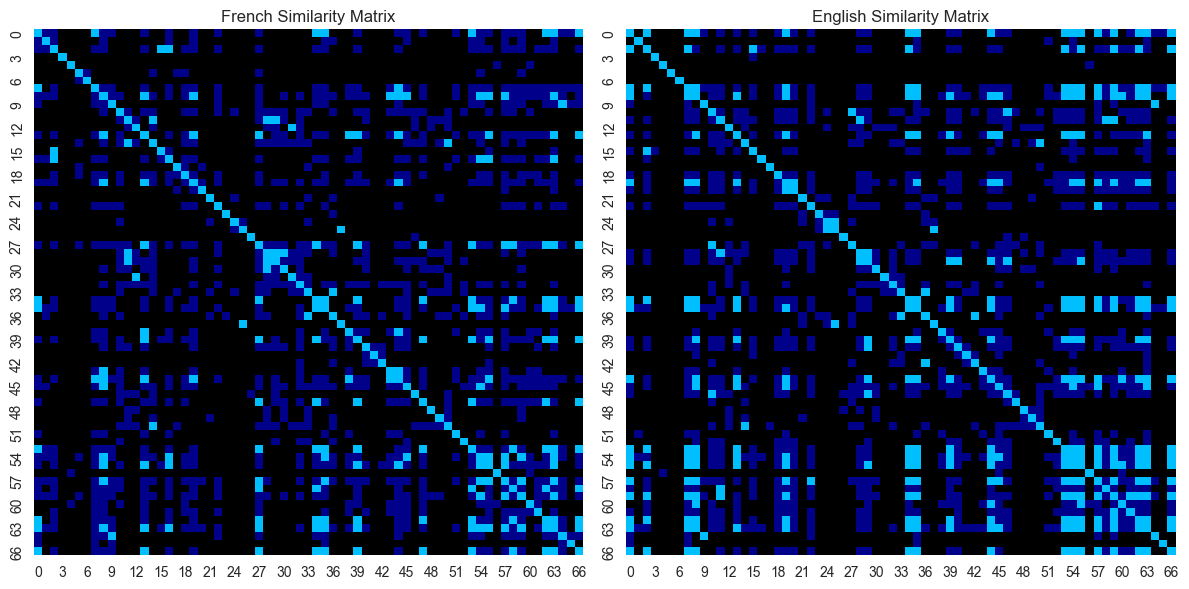

In [136]:
for pub_number in ['SAR 2024/023']:
    print(pub_number)
    print('with linebreaks')
    plot_both_language_heatmaps(corpus_df, sentence_encoder, pub_number)
    print('without linebreaks')
    plot_both_language_heatmaps(corpus_df_wo_linebreaks, sentence_encoder, pub_number)
    print()

RES 2012/076
with linebreaks


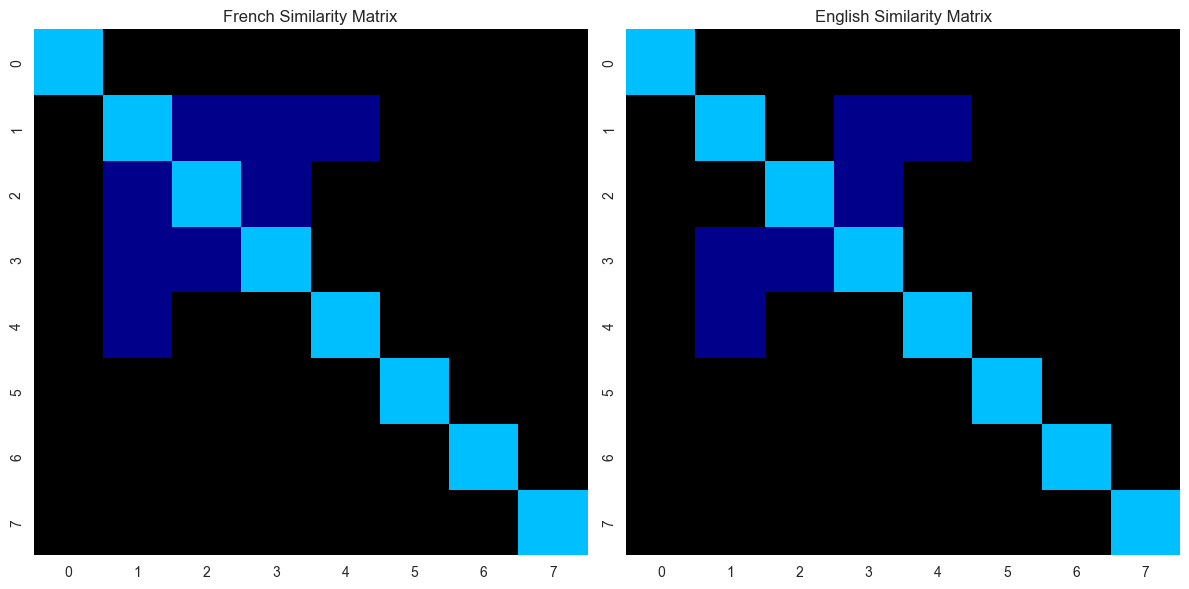

without linebreaks


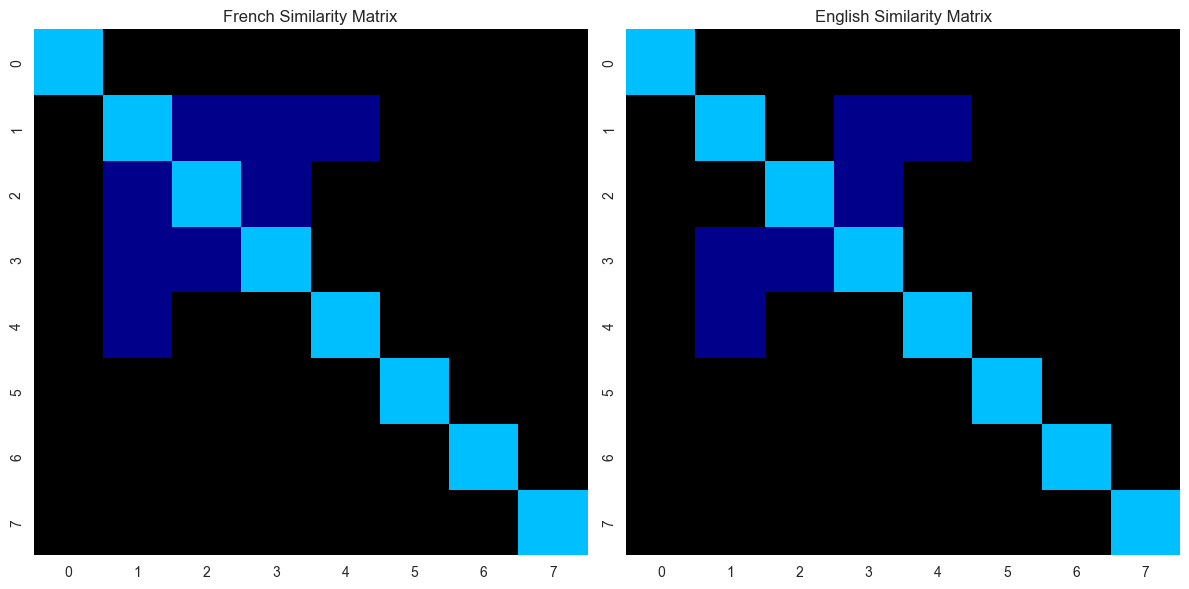


SAR 2015/004
with linebreaks


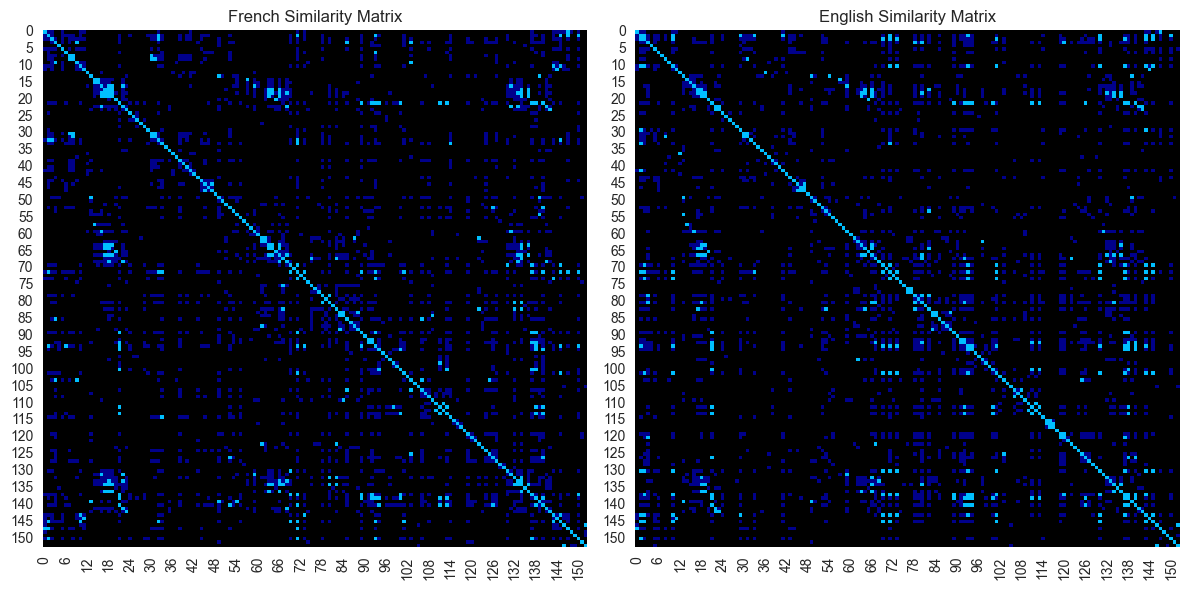

without linebreaks


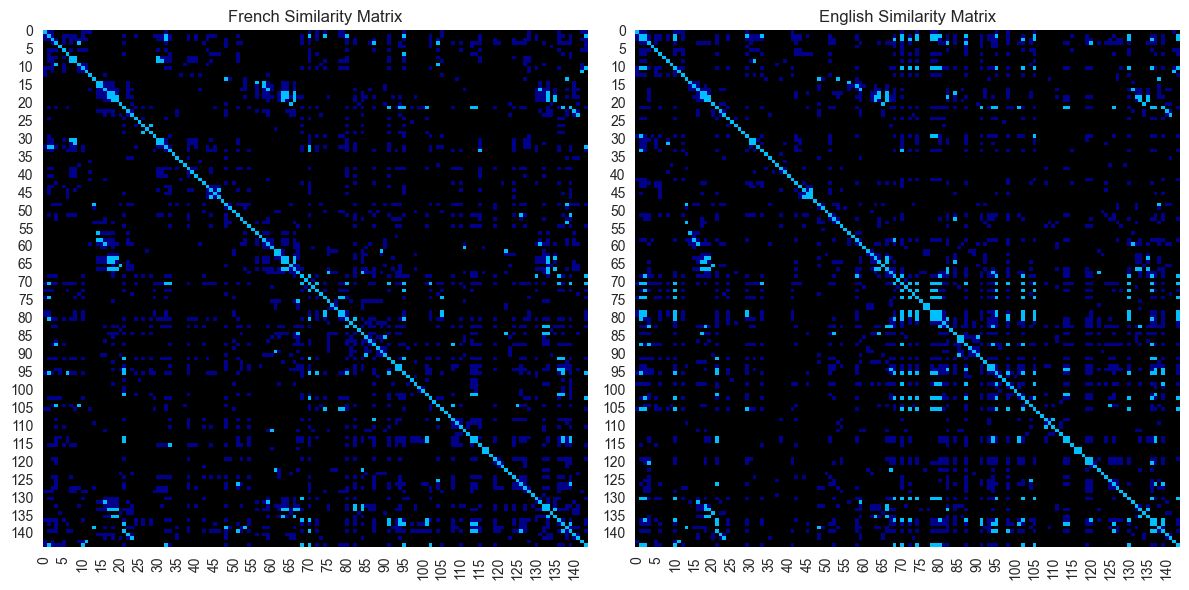


PRO 2023/011
with linebreaks


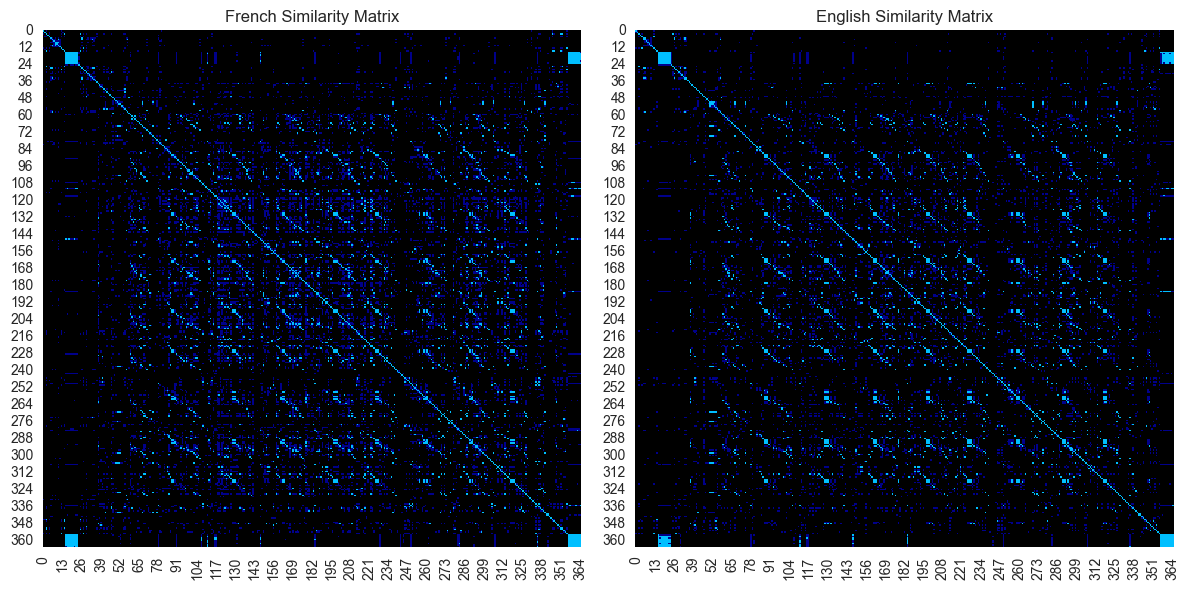

without linebreaks


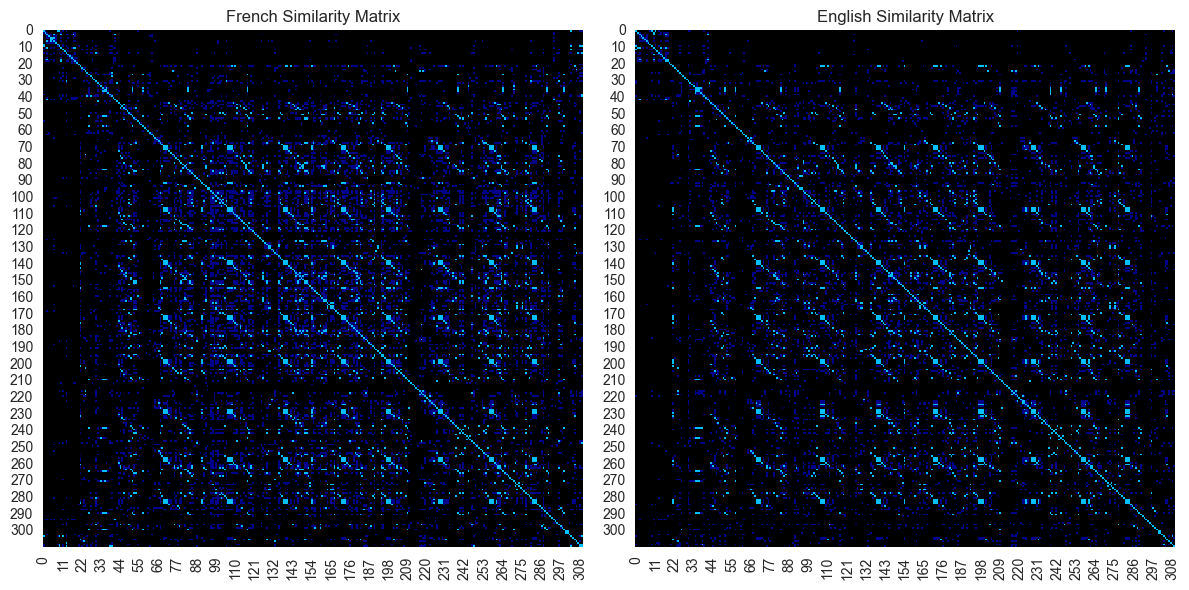


SCR 2019/011
with linebreaks


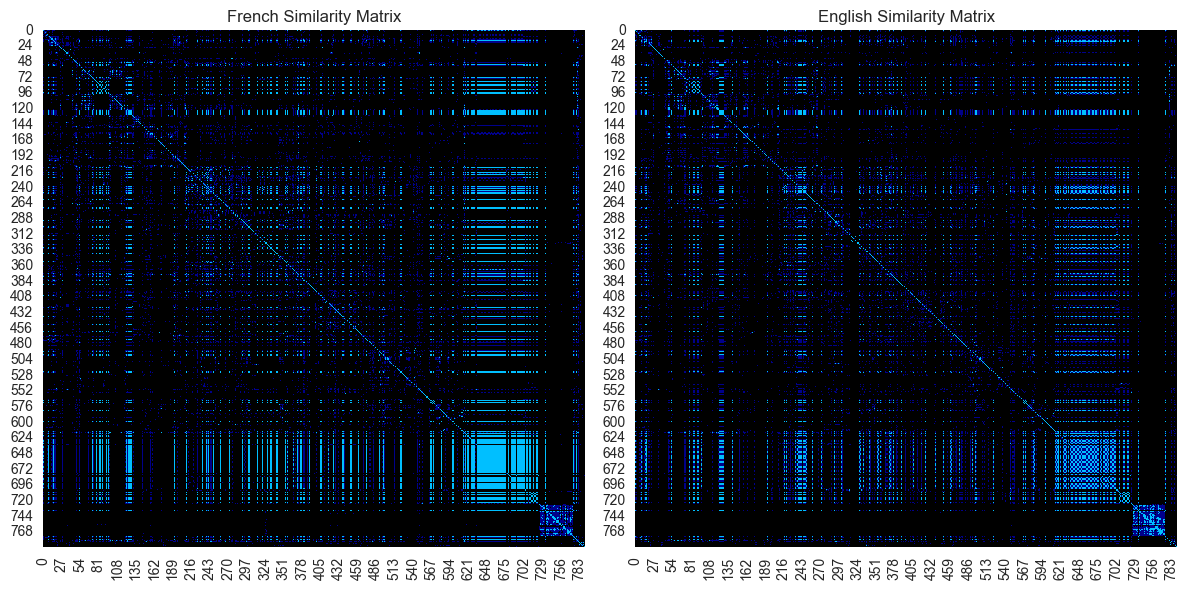

without linebreaks


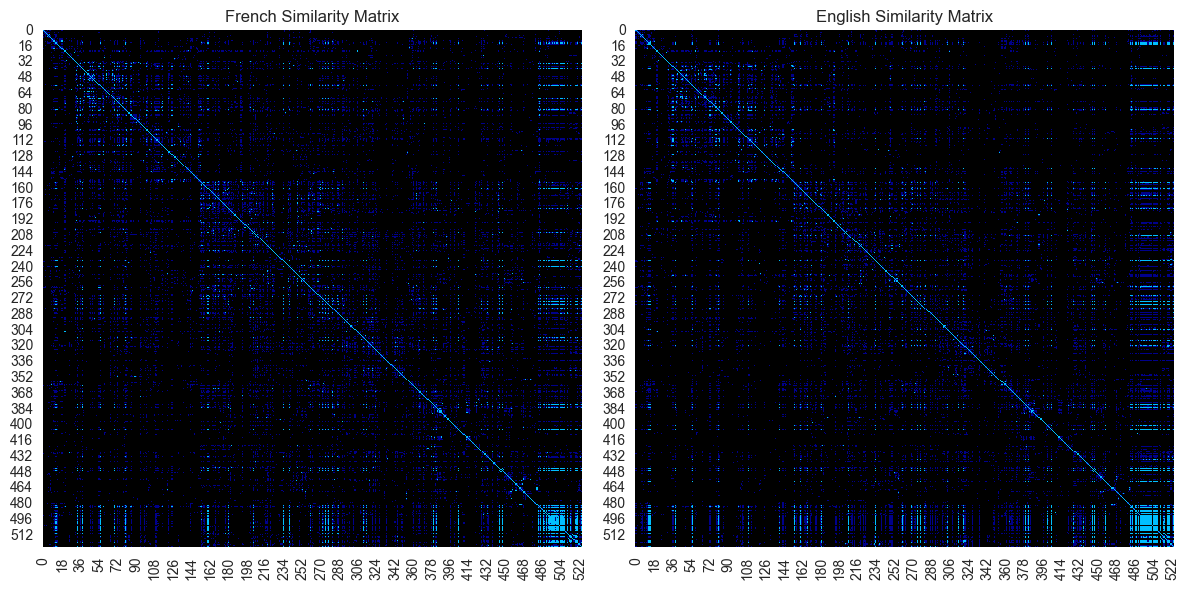


SSR 2004/024
with linebreaks


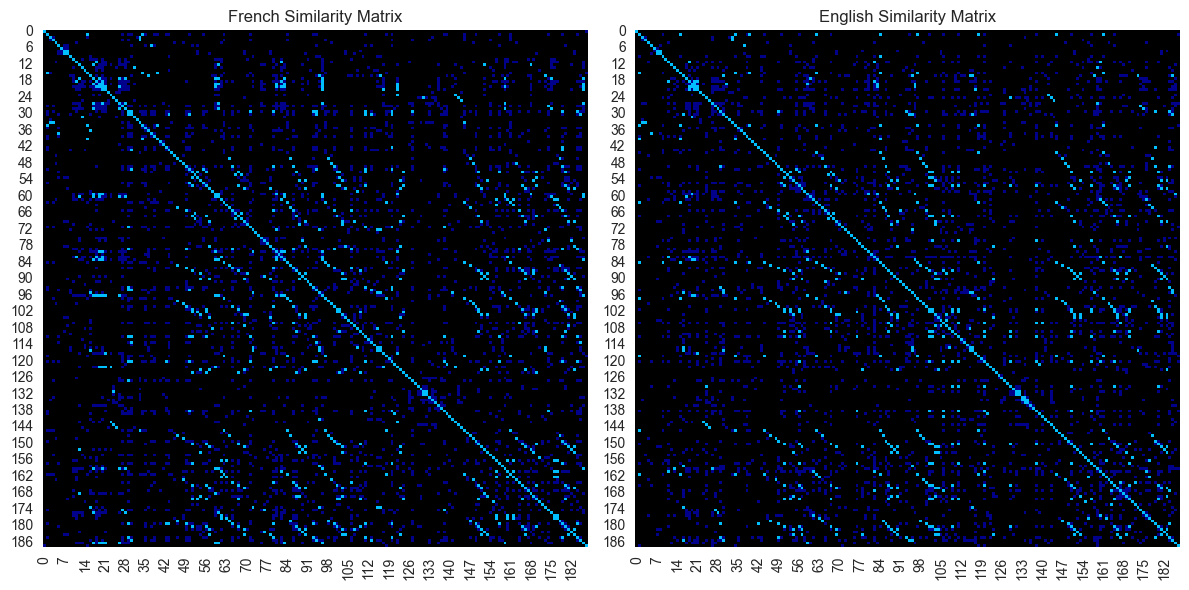

without linebreaks


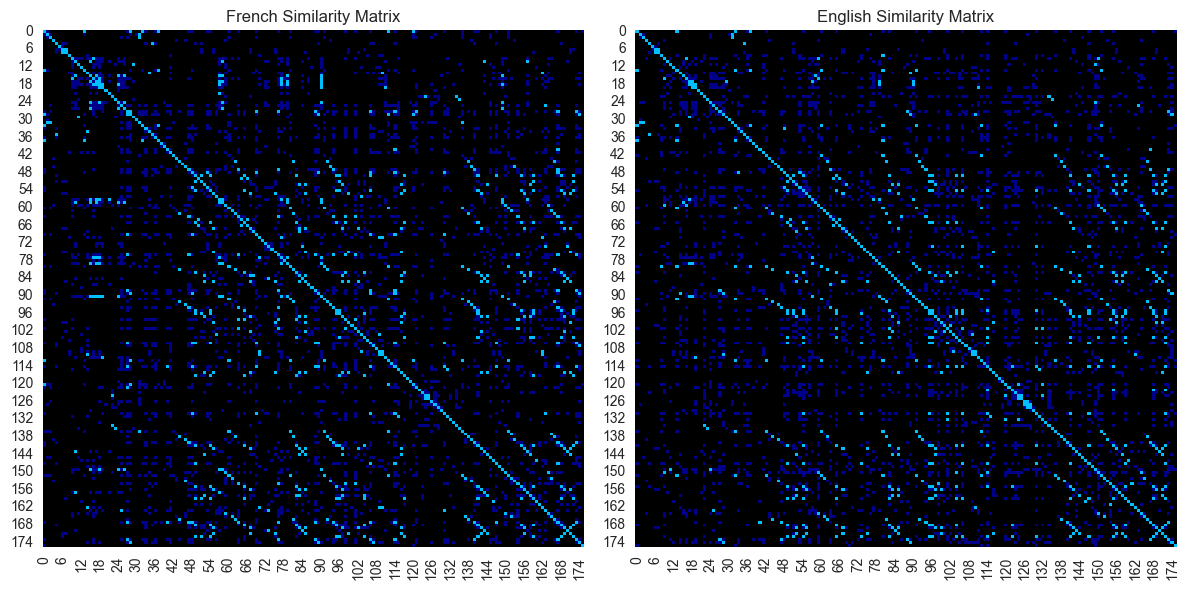


PRO 2022/020
with linebreaks


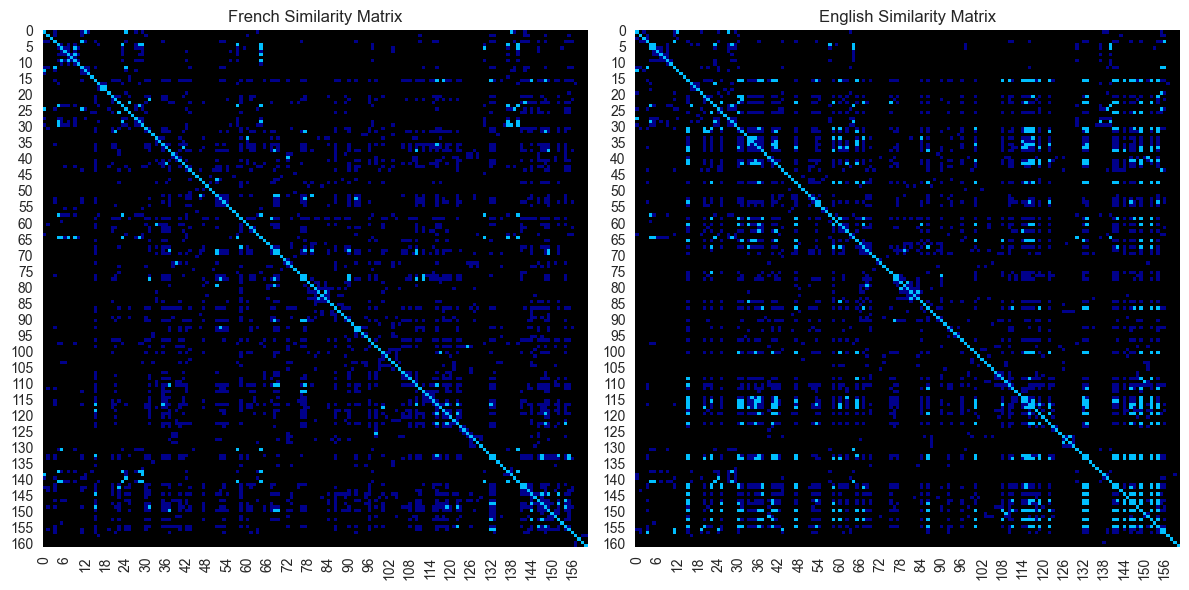

without linebreaks


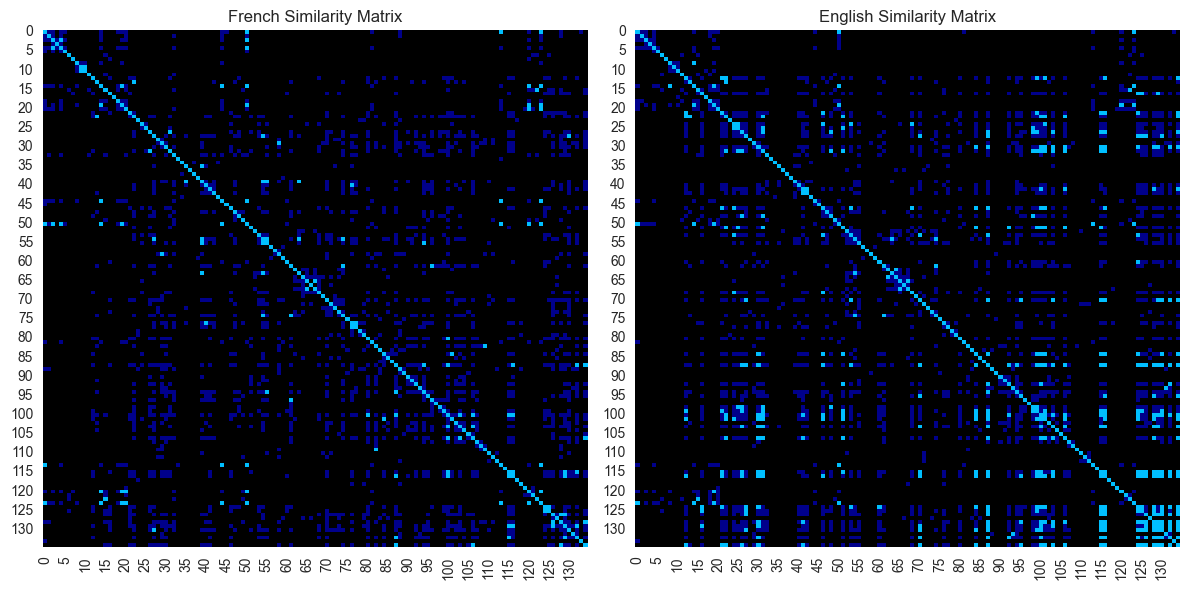


SCR 2020/049
with linebreaks


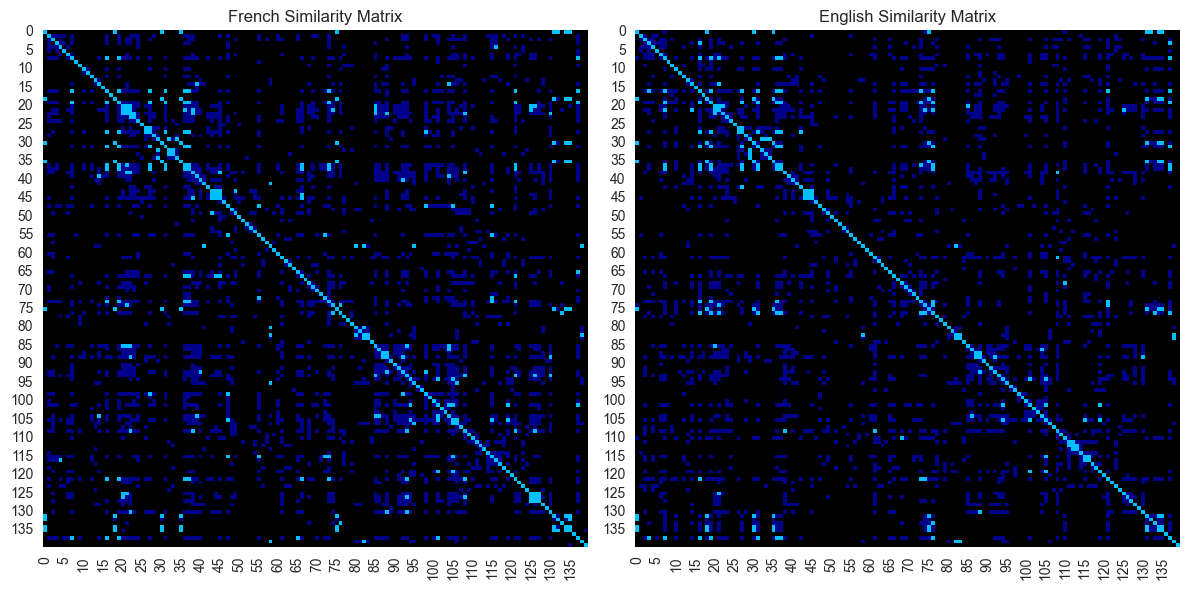

without linebreaks


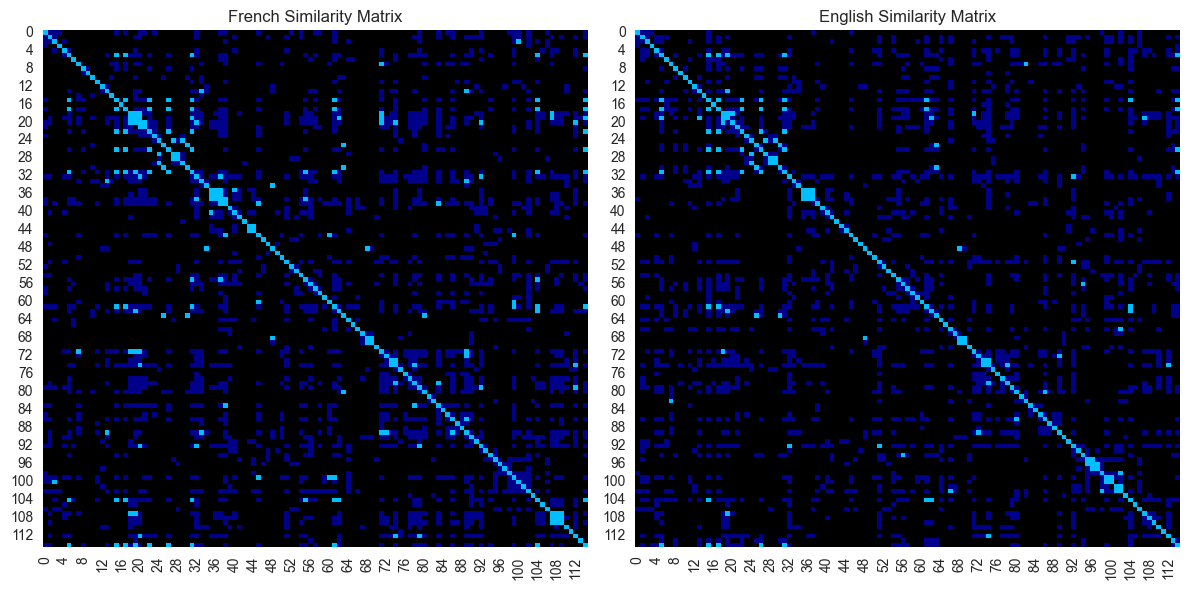


RES 1999/105
with linebreaks


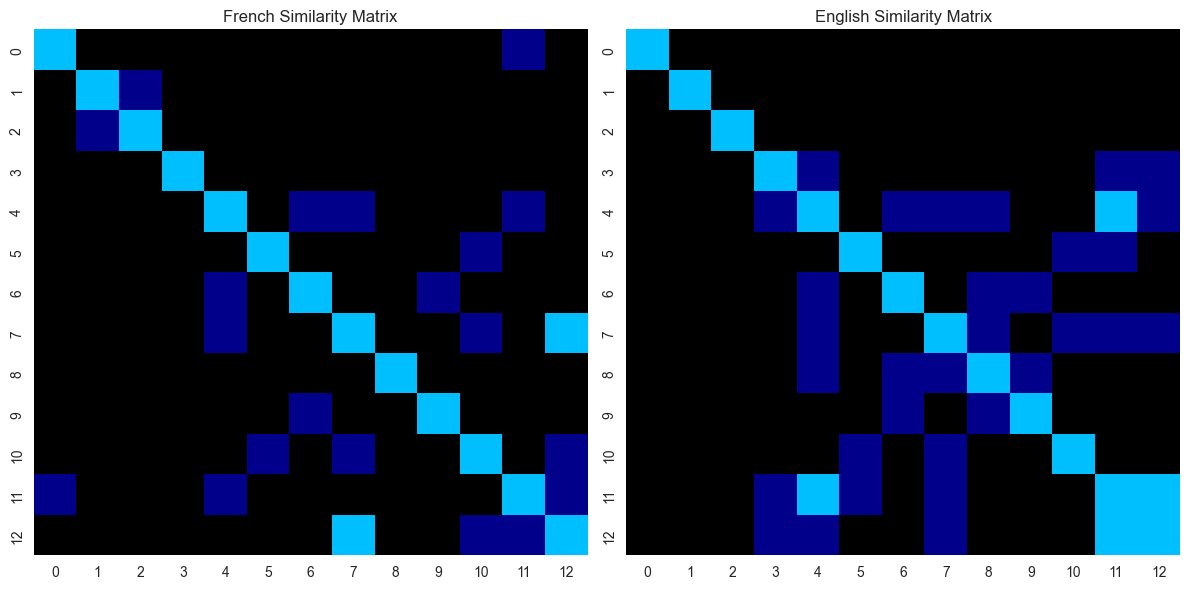

without linebreaks


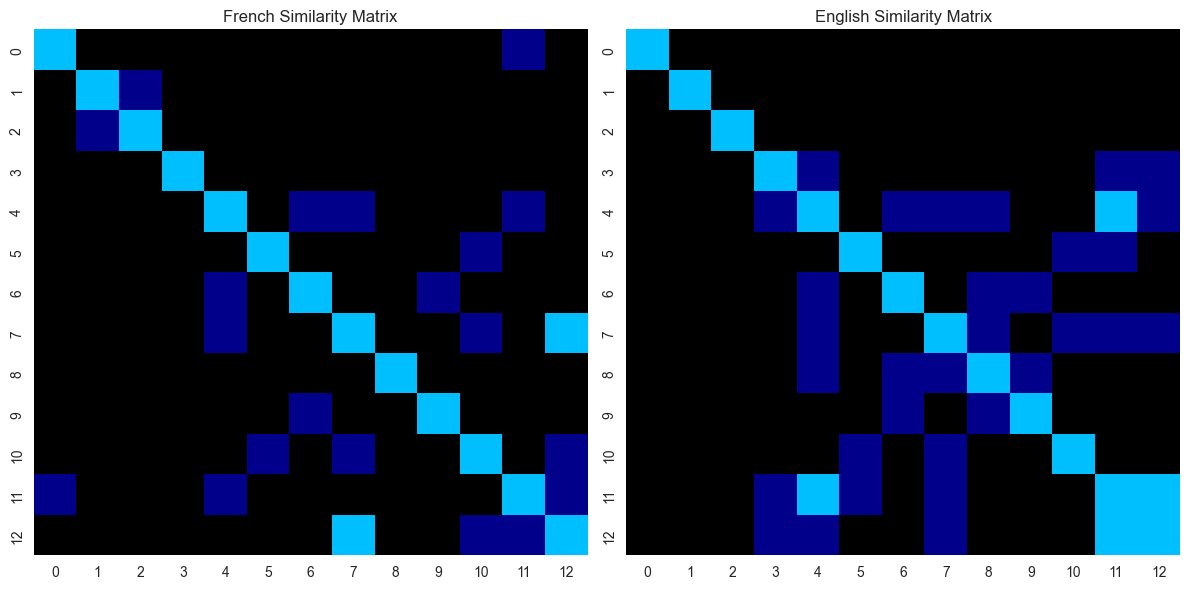


RES 2002/127
with linebreaks


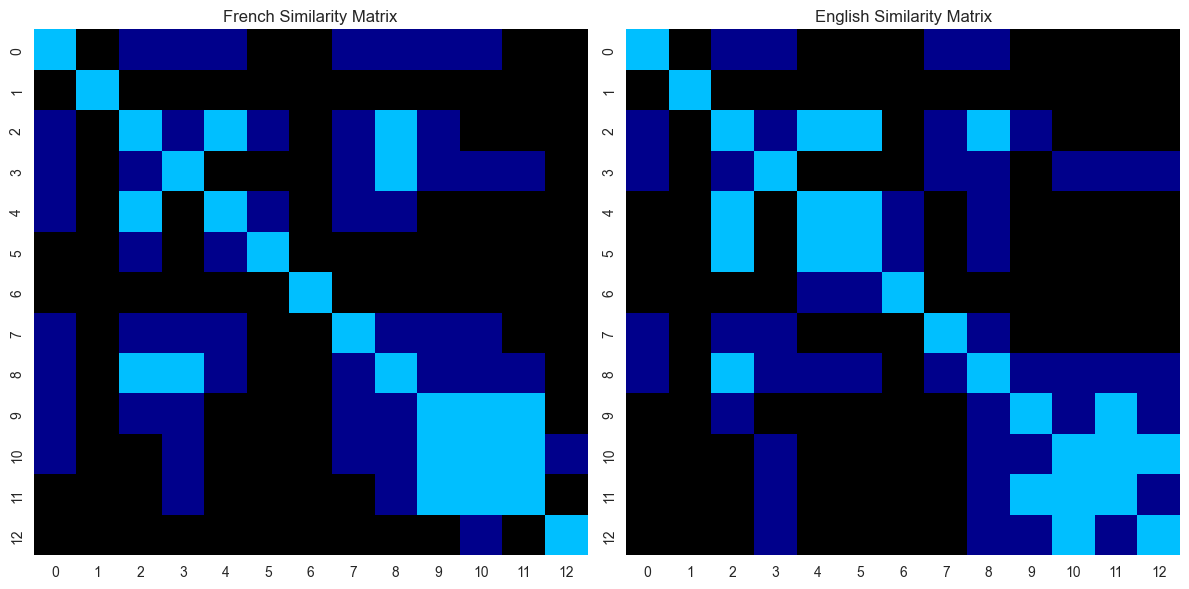

without linebreaks


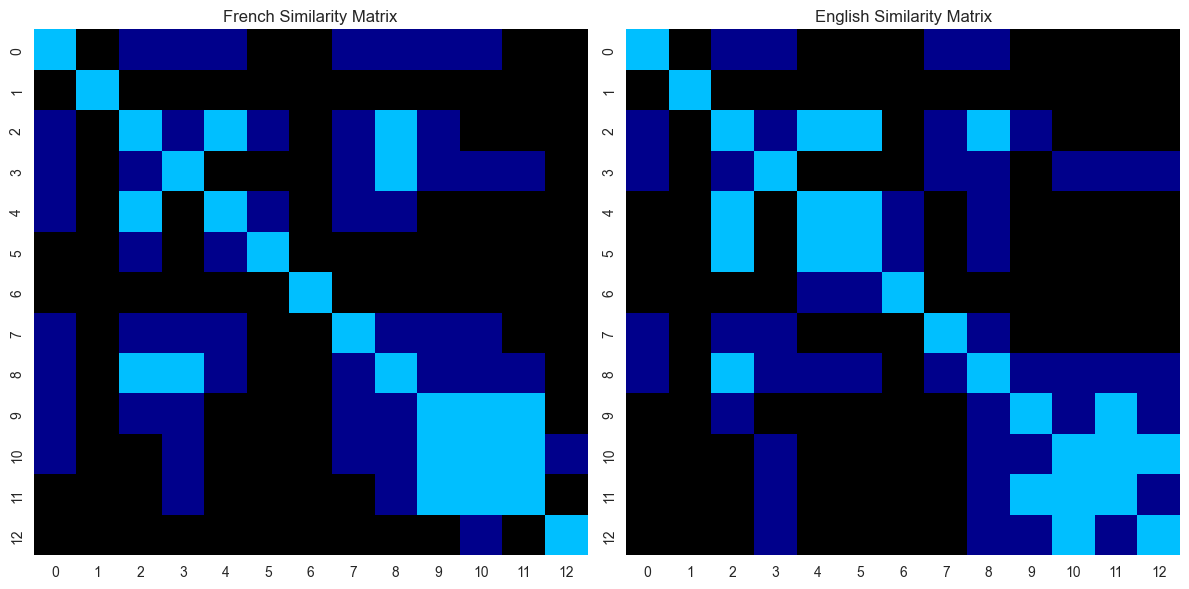


SAR 2019/049
with linebreaks


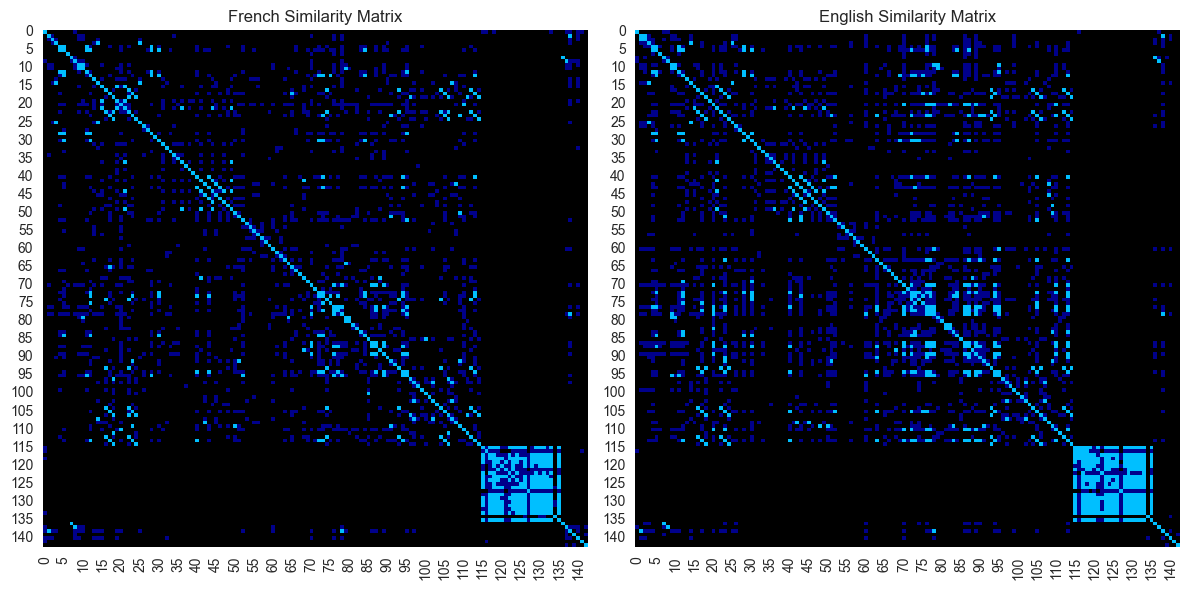

without linebreaks


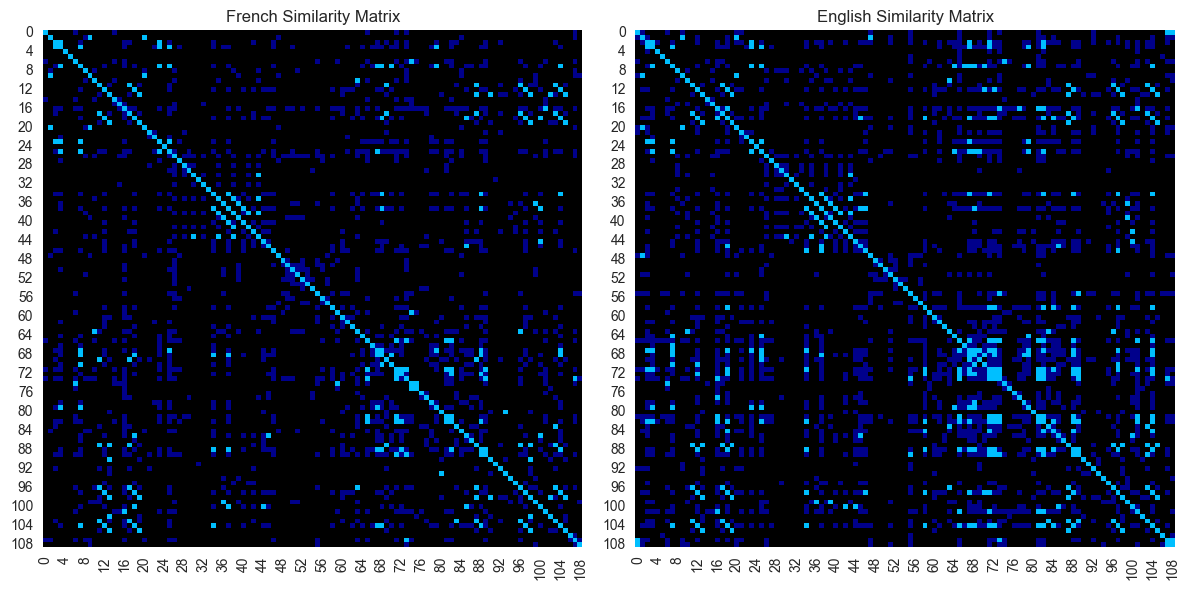

In [138]:
for pub_number in ['RES 2012/076', 'SAR 2015/004', 'PRO 2023/011', 'SCR 2019/011', 'SSR 2004/024', 'PRO 2022/020', 'SCR 2020/049', 'RES 1999/105', 'RES 2002/127', 'SAR 2019/049']:
    print(pub_number)
    print('with linebreaks')
    plot_both_language_heatmaps(corpus_df, sentence_encoder, pub_number)
    print('without linebreaks')
    plot_both_language_heatmaps(corpus_df_wo_linebreaks, sentence_encoder, pub_number)
    print()

In [16]:
# TODO: wo_linebreaks usually looks cleaner 
#  (not statistically much better, but by inspection, looks much cleaner)

SAR 2019/049
with linebreaks


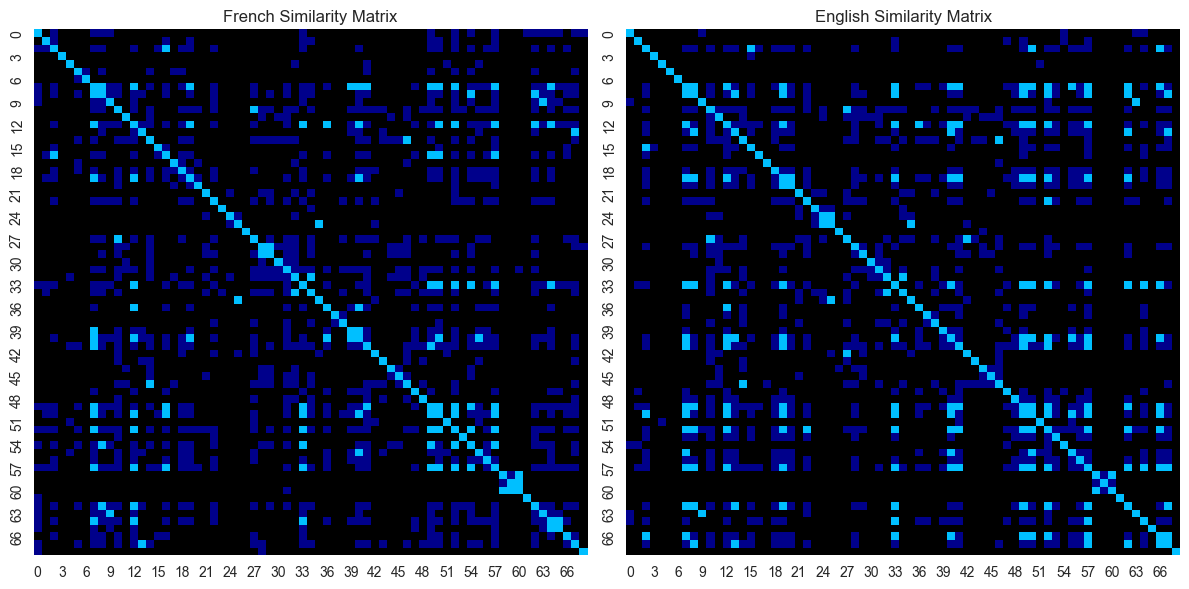

without linebreaks


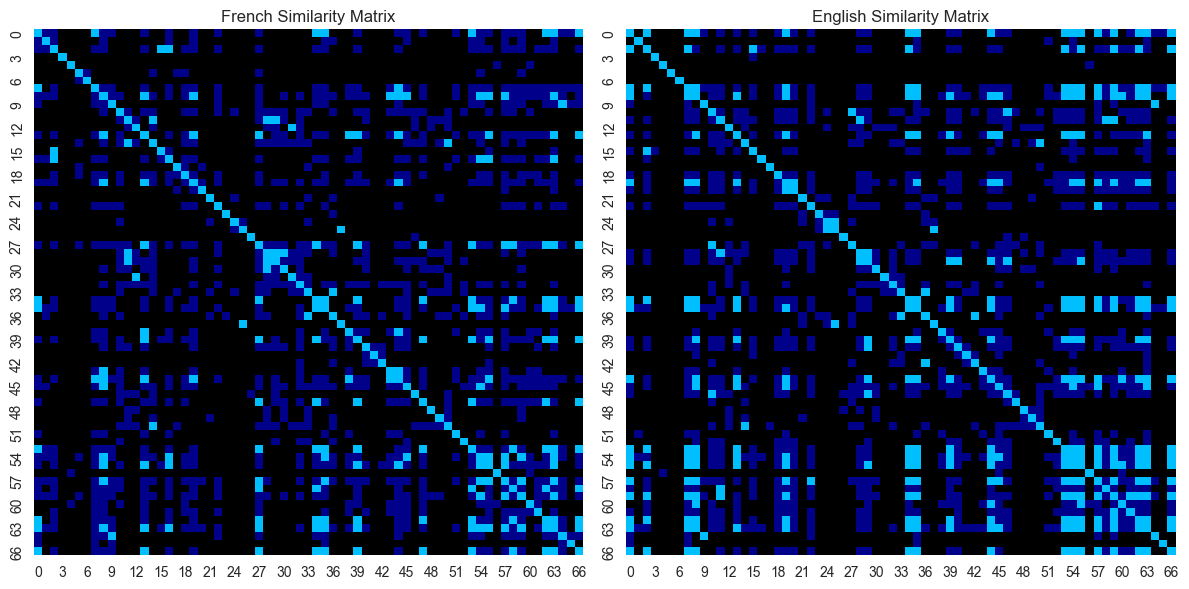

In [142]:
# TODO: figure out why this one actually looks worse
print(pub_number)
print('with linebreaks')
plot_both_language_heatmaps(corpus_df, sentence_encoder, 'SAR 2024/023')
print('without linebreaks')
plot_both_language_heatmaps(corpus_df_wo_linebreaks, sentence_encoder, 'SAR 2024/023')


In [100]:
from itertools import zip_longest

sar_2024023_en = corpus_df[corpus_df.pub_number == 'SAR 2024/023'].en.to_list()
sar_2024023_en_wo = corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.pub_number == 'SAR 2024/023'].en.to_list() 
sar_2024023_fr = corpus_df[corpus_df.pub_number == 'SAR 2024/023'].fr.to_list()
sar_2024023_fr_wo = corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.pub_number == 'SAR 2024/023'].fr.to_list()

sar_2024023_en.insert(7, "-----")
sar_2024023_en_wo.insert(9, "-----")
sar_2024023_en.insert(12, "-----")
sar_2024023_en_wo.insert(15, "-----")
sar_2024023_en.insert(31, "-----")
sar_2024023_en.insert(36, "-----")
sar_2024023_en.insert(41, "-----")
sar_2024023_en.insert(42, "-----")
sar_2024023_en.insert(48, "-----")
sar_2024023_en_wo.insert(49, "-----")
sar_2024023_en.insert(56, "-----")
sar_2024023_en.insert(65, "-----")
sar_2024023_en_wo.insert(67, "-----")
sar_2024023_en_wo.insert(68, "-----")
sar_2024023_en_wo.insert(69, "-----")
sar_2024023_en_wo.insert(70, "-----")
sar_2024023_en_wo.insert(71, "-----")
sar_2024023_en_wo.insert(73, "-----")
sar_2024023_en_wo.insert(76, "-----")
sar_2024023_en_wo.insert(77, "-----")

# # align translations by inspection
# for i, (x, y) in enumerate(zip_longest(sar_2024023_en, sar_2024023_en_wo)):
#     print(i)
#     print()
#     print(x)
#     print()
#     print(y)
#     print('\n\n\n')

sar_2024023_fr.insert(7, "-----")
sar_2024023_fr_wo.insert(9, "-----")
sar_2024023_fr.insert(12, "-----")
sar_2024023_fr_wo.insert(15, "-----")
sar_2024023_fr.insert(31, "-----")
sar_2024023_fr.insert(36, "-----")
sar_2024023_fr.insert(41, "-----")
sar_2024023_fr.insert(42, "-----")
sar_2024023_fr.insert(48, "-----")
sar_2024023_fr_wo.insert(49, "-----")
sar_2024023_fr.insert(56, "-----")
sar_2024023_fr.insert(65, "-----")
sar_2024023_fr_wo.insert(67, "-----")
sar_2024023_fr_wo.insert(68, "-----")
sar_2024023_fr_wo.insert(69, "-----")
sar_2024023_fr_wo.insert(70, "-----")
sar_2024023_fr_wo.insert(71, "-----")
sar_2024023_fr_wo.insert(73, "-----")
sar_2024023_fr_wo.insert(76, "-----")
sar_2024023_fr_wo.insert(77, "-----")
    
# len(sar_2024023_en), len(sar_2024023_en_wo), len(sar_2024023_fr), len(sar_2024023_fr_wo) 

df = pd.DataFrame({
    "EN": sar_2024023_en,
    "EN_wo": sar_2024023_en_wo,
    "FR": sar_2024023_fr,
    "FR_wo": sar_2024023_fr_wo
})
df = df.map(clean_text)


In [118]:
# for i, row in df.iterrows():
#     display(pd.DataFrame(row))

In [117]:
for i, row in corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.pub_number == "SAR 2024/023"].reset_index(drop=True).iterrows():
    if i > 52:
        display(pd.DataFrame(row))

,53
pub_number,SAR 2024/023
fr,Région de la Capitale Nationale Évaluation des stocks de phoque commun de l Atlantique (Phoca vitulina vitulina) au Canada pour 2019 à 2021 8 Figure 3
en,National Capital Region Stock Assessment of Atlantic Harbour Seals (Phoca vitulina vitulina) in Canada for 2019 2021 6 Figure 3
similarity,0.784


,54
pub_number,SAR 2024/023
fr,CONCLUSIONS Il s agit du premier relevé réalisé à l échelle du Canada atlantique pour examiner l abondance et la répartition du phoque commun
en,CONCLUSIONS This is the first range-wide survey in Atlantic Canada to examine harbour seal abundance and distribution
similarity,0.746


,55
pub_number,SAR 2024/023
fr,L estimation de l abondance du phoque commun dans le Canada atlantique est de 25 200 phoques (arrondi à la centaine près)
en,"The abundance estimate of harbour seals in Atlantic Canada is 25,200 seals (rounded to the nearest 100)"
similarity,0.736


,56
pub_number,SAR 2024/023
fr,"Avec une seule estimation de l abondance, il n est pas possible de fournir de l information sur les tendances des populations"
en,"With a single abundance estimate, it is not possible to provide information on population trends"
similarity,0.956


,57
pub_number,SAR 2024/023
fr,AUTRES CONSIDÉRATIONS Il est nécessaire de réaliser des relevés de façon périodique pour surveiller l abondance et les tendances du phoque commun dans le Canada atlantique
en,OTHER CONSIDERATIONS Regular surveys are needed to monitor the abundance and trends of harbour seals in Atlantic Canada
similarity,0.757


,58
pub_number,SAR 2024/023
fr,"La concurrence accrue avec le Région de la Capitale Nationale Évaluation des stocks de phoque commun de l Atlantique (Phoca vitulina vitulina) au Canada pour 2019 à 2021 9 phoque gris, les augmentations de la présence de prédateurs marins comme le grand requin blanc (Carcharodon carcharias), ain..."
en,"Increased competition with grey seals, increases in the presence of marine predators such as white sharks (Carcharodon carcharias), and other impacts related to climate change are likely to affect the dynamics of this small coastal seal"
similarity,0.813


,59
pub_number,SAR 2024/023
fr,Il faudrait mener des efforts de recherche supplémentaires dans l ensemble du Canada atlantique en vue de mieux comprendre la dispersion et les déplacements saisonniers du phoque commun et d obtenir des facteurs de correction d échouerie pour un échantillon représentatif de la population selon l...
en,"Additional research efforts would be needed throughout Atlantic Canada to better understand the seasonal movements and National Capital Region Stock Assessment of Atlantic Harbour Seals (Phoca vitulina vitulina) in Canada for 2019 2021 7 dispersal of harbour seals, and to obtain haul-out correct..."
similarity,0.725


,60
pub_number,SAR 2024/023
fr,"Cette estimation de l abondance, ainsi que son PBP associé (1 729 phoques), n inclut pas les individus qui se reproduisent dans les eaux canadiennes"
en,"This abundance estimate, and its associated PBR (1,729 seals), does not include individuals which breed in Canadian waters"
similarity,0.856


,61
pub_number,SAR 2024/023
fr,Les déplacements transfrontaliers saisonniers de phoques qui se reproduisent dans les eaux américaines ou françaises ne sont pas pris en compte dans l estimation de la population ou dans le PBP pour les eaux canadiennes de l Atlantique
en,"Seasonal, transboundary movements of seals which breed in US or French waters are not accounted for in the population estimate or PBR for Atlantic Canadian waters"
similarity,0.824


,62
pub_number,SAR 2024/023
fr,Région de la Capitale Nationale Évaluation des stocks de phoque commun de l Atlantique (Phoca vitulina vitulina) au Canada pour 2019 à 2021 10 Tableau 1
en,National Capital Region Stock assessment of Atlantic harbour seals (Phoca vitulina vitulina) in Canada for 2019 2021 8 Table 1
similarity,0.773


,63
pub_number,SAR 2024/023
fr,Dénombrements et abondances estimées par région et zone de relevé pour le relevé du phoque commun dans l ensemble du Canada atlantique pour 2019 à 2021
en,Counts and estimated abundances by survey regions and areas for the 2019 21 Atlantic Canada wide harbour seal survey
similarity,0.763


,64
pub_number,SAR 2024/023
fr,"Toute autre publication découlant de cette réunion sera publiée, lorsqu elle sera disponible, sur le calendrier des avis scientifiques de Pêches et Océans Canada (MPO)"
en,Additional publications from this meeting will be posted on the Fisheries and Oceans Canada (DFO) Science Advisory Schedule as they become available
similarity,0.865


,65
pub_number,SAR 2024/023
fr,"Fs70-6 2024-023F-PDF Sa Majesté le Roi du chef du Canada, représenté par le ministre du ministère des Pêches et des Océans, 2024 La présente publication doit être citée comme suit : MPO"
en,"Fs70-6 2024-023E-PDF His Majesty the King in Right of Canada, as represented by the Minister of the Department of Fisheries and Oceans, 2024 Correct Citation for this Publication: DFO"
similarity,0.910


,66
pub_number,SAR 2024/023
fr,Évaluation des stocks de phoque commun de l atlantique (Phoca vitulina vitulina) au canada pour 2019 à 2021
en,Stock Assessment of Atlantic Harbour Seals (Phoca vitulina vitulina) in Canada for 2019 2021
similarity,0.808


In [144]:
for i, row in corpus_df[corpus_df.pub_number == "SAR 2024/023"].reset_index(drop=True).iterrows():
    if i > 52:
        display(pd.DataFrame(row))

,53
pub_number,SAR 2024/023
fr,"phoque gris, les augmentations de la présence de prédateurs marins comme le grand requin \nblanc (Carcharodon carcharias), ainsi que d’autres répercussions liées aux changements \nclimatiques, sont susceptibles d’influer sur la dynamique de ce petit phoque côtier"
en,"Increased competition with grey seals, increases in the presence of marine predators \nsuch as white sharks (Carcharodon carcharias), and other impacts related to climate change \nare likely to affect the dynamics of this small coastal seal"
similarity,0.866


,54
pub_number,SAR 2024/023
fr,Il faudrait \nmener des efforts de recherche supplémentaires dans l’ensemble du Canada atlantique en vue \nde mieux comprendre la dispersion et les déplacements saisonniers du phoque commun et \nd’obtenir des facteurs de correction d’échouerie pour un échantillon représentatif de la \npopulation...
en,Additional research efforts would be \nneeded throughout Atlantic Canada to better understand the seasonal movements and
similarity,0.791


,55
pub_number,SAR 2024/023
fr,"Cette estimation de l’abondance, ainsi que son PBP associé \n(1 729 phoques), n’inclut pas les individus qui se reproduisent dans les eaux canadiennes"
en,"This \nabundance estimate, and its associated PBR (1,729 seals), does not include individuals which \nbreed in Canadian waters"
similarity,0.860


,56
pub_number,SAR 2024/023
fr,Les déplacements transfrontaliers saisonniers de phoques qui se \nreproduisent dans les eaux américaines ou françaises ne sont pas pris en compte dans \nl’estimation de la population ou dans le PBP pour les eaux canadiennes de l’Atlantique
en,"Seasonal, \ntransboundary movements of seals which breed in US or French waters are not accounted for in \nthe population estimate or PBR for Atlantic Canadian waters"
similarity,0.826


,57
pub_number,SAR 2024/023
fr,Dénombrements et abondances estimées par région et zone de relevé pour le relevé du phoque commun dans l’ensemble du Canada \natlantique pour 2019 à 2021
en,Counts and estimated abundances by survey regions and areas for the 2019–21 Atlantic Canada wide harbour seal survey
similarity,0.750


,58
pub_number,SAR 2024/023
fr,"2019 Estuaire du Saint-Laurent 13-21 juin 2,55 (CV de 16,02 %) 2 140 5 452 (3 984-7 461) \nSud du golfe 4-11 juin - 1 799 4 583 (3 348-6 274) \nNord du Golfe 22-28 juin - 979 2 494 (1 819-3 420) \nCôte ouest de T.-N.-L"
en,"Southern Gulf June 4–11 “ 1,799 4,583 (3,348–6,274) \nNorthern Gulf June 22–28 “ 979 2,494 (1,819–3,420) \nWest Coast NL June 29–30 “ 796 2,028 (1,478–2,783) \nTotal - - 5,714 14,557 (12,288–17,245)"
similarity,0.786


,59
pub_number,SAR 2024/023
fr,Côte est 19 juin; 2-17 juillet - 308 785 (568-1 085) \nCap Breton 26 juin; 4-16 juillet - 331 843 (611-1 165)
en,"SWNS June 18–25; July 5-7 “ 1,043 2,657 (1,938–3,643) \nEastern Shore June 19; July 2–17 “ 308 785 (568–1,085) \nCape Breton June 26; July 4–16 “ 331 843 (611–1,165)"
similarity,0.825


,60
pub_number,SAR 2024/023
fr,"2021 Côte sudb 6-8 juillet 2,55 (CV de 16,02 %) 706 1 799 (1 310-2 470) \nCôte sudc 24 juillet-19 août 1,64 (CV de 8,67 %) 1 257 2 076 (1 746-2 468) \nCôte nord-est 9-14 juillet 2,55 (CV de 16,02 %) 324 825 (598-1 140) \nBaie Sandwich, Labrador 14 juillet - 0 0 \nTotal - - 2 287 4 700 (5 033–6 ..."
en,"2021 South Coast b July 6–8 2.55 (CV 16.02%) 706 1,799 (1,310–2,470) \nSouth Coast c July 24–August 19 1.64 (CV 8.67%) 1,257 2,076 (1,746–2,468) \nNortheast Coast July 9–July 14 2.55 (CV 16.02%) 324 825 (598–1,140) \nSandwich Bay, Labrador July 14 “ 0 0 \nTotal - - 2,287 4,700 (5,033–6,714)"
similarity,0.745


,61
pub_number,SAR 2024/023
fr,"et des Prairies \nWright, Andrew Secteur des sciences du MPO, région de l’Arctique \nWright, Brianna Secteur des sciences du MPO, région du Pacifique \nYurkowski, Dave Secteur des sciences du MPO, région de l’Ontario"
en,"Name Affiliation \nSmith, Heather DFO - Science, National Capital Region \nTucker, Strahan DFO - Science, Pacific Region \nVan de Walle, Joannie DFO - Science, Quebec Region \nWatt, Cortney DFO - Science, Ontario and Prairie Region \nWright, Andrew DFO - Science, Arctic Region \nWright, Brianna ..."
similarity,0.701


,62
pub_number,SAR 2024/023
fr,SOURCES DE RENSEIGNEMENTS \nLe présent avis scientifique découle de l’examen par les pairs national du 16 au 20 octobre \n2023 sur l’évaluation de la population de phoques communs de l'Atlantique Nord-Ouest et \nniveaux de prélèvement biologique potentiel
en,"SOURCES OF INFORMATION \nThis Science Advisory Report is from the October 16-20, 2023 National Peer Review on the NW \nAtlantic Harbour Seal Population Assessment and Potential Biological Removal Levels"
similarity,0.717


,63
pub_number,SAR 2024/023
fr,"Toute autre publication découlant de cette réunion \nsera publiée, lorsqu’elle sera disponible, sur le calendrier des avis scientifiques de Pêches et \nOcéans Canada (MPO)"
en,Additional publications from this meeting will be posted on the Fisheries and Oceans Canada \n(DFO) Science Advisory Schedule as they become available
similarity,0.867


,64
pub_number,SAR 2024/023
fr,CE RAPPORT EST DISPONIBLE AUPRÈS DU : \nPêches et Océans Canada
en,National Capital Region \nFisheries and Oceans Canada
similarity,0.875


,65
pub_number,SAR 2024/023
fr,"© Sa Majesté le Roi du chef du Canada, représenté par le ministre \ndu ministère des Pêches et des Océans, 2024"
en,"Fs70-6/2024-023E-PDF \n© His Majesty the King in Right of Canada, as represented by the Minister of the"
similarity,0.746


,66
pub_number,SAR 2024/023
fr,Évaluation des stocks de phoque commun de l’atlantique (Phoca vitulina vitulina)
en,Stock Assessment of Atlantic Harbour Seals (Phoca vitulina vitulina) in Canada for
similarity,0.745


,67
pub_number,SAR 2024/023
fr,ÉVALUATION DES STOCKS DE PHOQUE COMMUN DE L’ATLANTIQUE (PHOCA VITULINA VITULINA) AU CANADA POUR 2019 À 2021\n\tSOMMAIRE\n\tRENSEIGNEMENTS DE BASE\n\tÉVALUATION\n\tCouverture des relevés et méthodes\n\tFacteurs de correction\n\tEstimations de l’abondance\n\tPrélèvement biologique potentiel (PBP)\...
en,STOCK ASSESSMENT OF ATLANTIC HARBOUR SEALS (PHOCA VITULINA VITULINA) IN CANADA FOR 2019–2021\n\tSUMMARY\n\tBACKGROUND\n\tASSESSMENT\n\tSurvey Coverage and Methods\n\tCorrection Factors\n\tEstimates of Abundance\n\tPotential Biological Removal (PBR)\n\tSources of Uncertainty
similarity,0.727


,68
pub_number,SAR 2024/023
fr,CONCLUSIONS\n\tAUTRES CONSIDÉRATIONS\n\tLISTE DES PARTICIPANTS DE LA RÉUNION\n\tSOURCES DE RENSEIGNEMENTS\n\tCE RAPPORT EST DISPONIBLE AUPRÈS DU :
en,CONCLUSIONS\n\tOTHER CONSIDERATIONS\n\tLIST OF MEETING PARTICIPANTS\n\tSOURCES OF INFORMATION\n\tTHIS REPORT IS AVAILABLE FROM THE:
similarity,0.728


# what is the best exclusion range for max similarity?

In [18]:
# how many good datapoints?

corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > 20].shape[0]

745742

In [19]:
# percent good

corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > 20].shape[0] / corpus_df_wo_linebreaks.shape[0]

0.9573670230861762

In [220]:
corpus_value_counts = pd.DataFrame(corpus_df_wo_linebreaks.pub_number.value_counts())

similarity_score_df = pd.DataFrame([
    (n, corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > n].similarity.mean())
    for n in range(3000)
], columns=["n", "mean_similarity"])

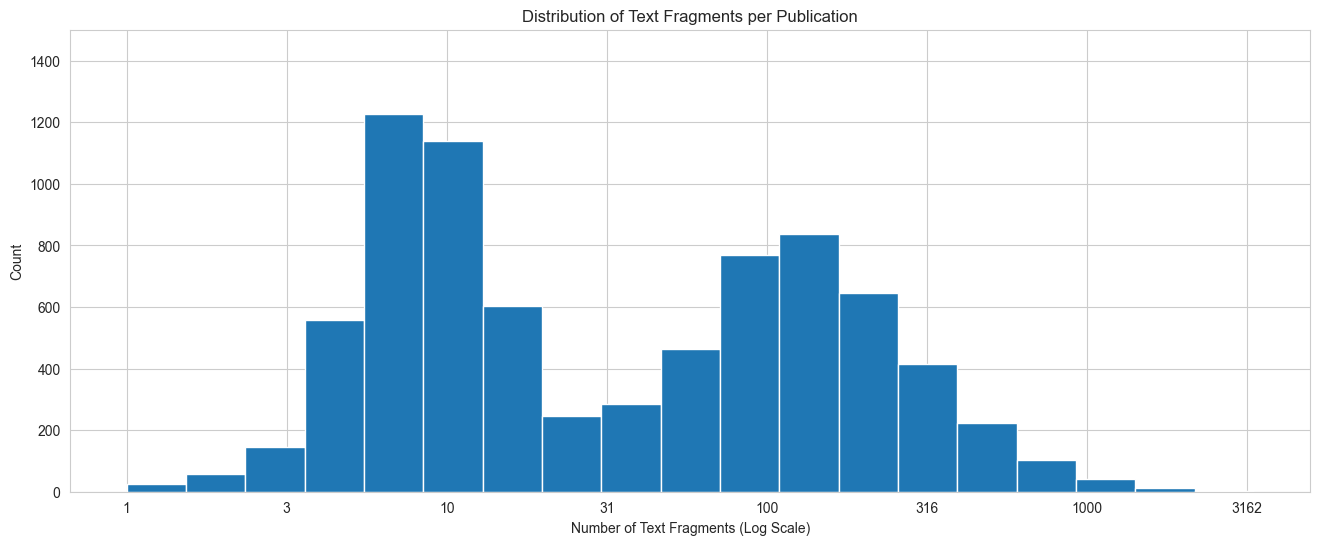

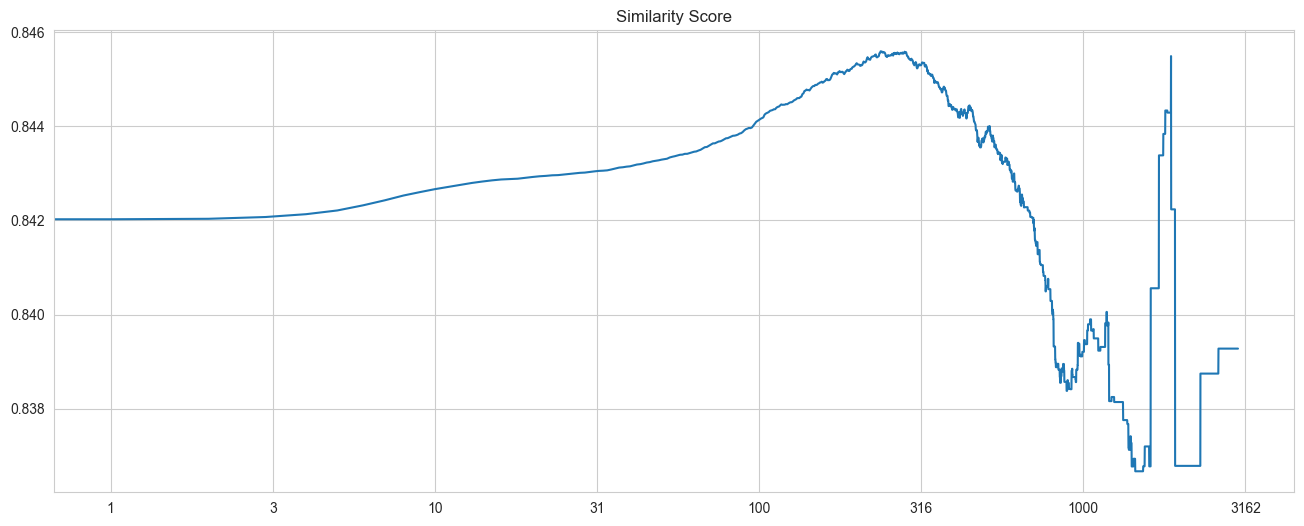

In [221]:
# counts
min_val = corpus_value_counts['count'].min()
max_val = corpus_value_counts['count'].max()
bins = np.logspace(np.log10(min_val), np.log10(max_val), num=20)

fig, ax = plt.subplots(figsize=(16, 6))
corpus_value_counts.hist(
    bins=bins,
    ax=ax,
    grid=True
)

ax.set_xscale("log")
x_ticks = np.logspace(np.log10(1), np.log10(10000), num=9)[:-1]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{int(x)}" for x in x_ticks]) 


ax.set_ylim(0, 1500)
ax.set_xlabel("Number of Text Fragments (Log Scale)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Text Fragments per Publication")

plt.show()

# similarity score
fig, ax = plt.subplots(figsize=(16, 6))
similarity_score_df.mean_similarity.plot()

ax.set_xscale("log")
x_ticks = np.logspace(np.log10(1), np.log10(10000), num=9)[:-1]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{int(x)}" for x in x_ticks]) 

ax.set_title("Similarity Score")

plt.show()


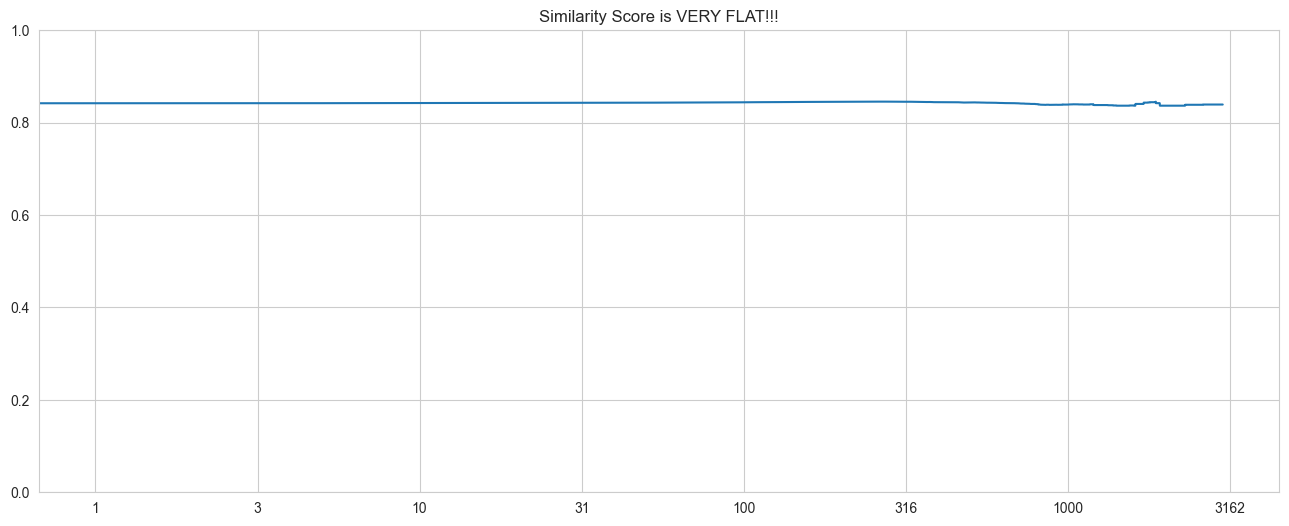

In [222]:
# TODO: decide on 10 or 12 or maybe just forget about it?
#  TODO: decide if more appendix cleaning is possible (internal similarity didn't work great, but we can revisit with subset of only huge pub numbers where score drops)

fig, ax = plt.subplots(figsize=(16, 6))
similarity_score_df.mean_similarity.plot()

ax.set_xscale("log")
x_ticks = np.logspace(np.log10(1), np.log10(10000), num=9)[:-1]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{int(x)}" for x in x_ticks]) 

ax.set_ylim(0, 1)

ax.set_title("Similarity Score is VERY FLAT!!!")

plt.show()

In [224]:
# TODO: huge pub numbers, similarity index stuff redux
n_big = 500
corpus_df_wo_linebreaks[corpus_df_wo_linebreaks.groupby("pub_number")["pub_number"].transform("count") > 500].pub_number.nunique()

225

# clean text

In [17]:
# TODO: clean text
#  remove characters, numbers, etc? 
#  remove names, contact info, etc?
#  remove sections from appendices (extremely repeated within the same language)
#  make sure errors from website do not make it into the training data


